In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [2]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)
latent_dim = 100
NOISE_SIZE = 100
EPSILON = 0.00005
LR_D = 0.00004
LR_G = 0.0004
BETA1 = 0.5

In [3]:
#prep image
baseDir = "../input/cropped/"

train_x = []

characterNames =[]
counter = 0
for imgname in  os.listdir(baseDir + '/'):
    if ".png" in imgname:
        img = Image.open(baseDir +'/' + imgname)
        img.thumbnail((img_shape[0],img_shape[1]), Image.ANTIALIAS)
        
        x = np.asarray(img)
        x = x / 255

        train_x.append(x)
        counter += 1
     
print("loaded!")
X_train = np.array(train_x)
print(X_train.shape)

loaded!
(9877, 64, 64, 3)


In [4]:
#generator function
generator = Sequential()

generator.add(Dense(1024*4*4, activation='relu',input_dim=NOISE_SIZE))
generator.add(Reshape((4, 4, 1024)))
generator.add(LeakyReLU(alpha=0.2))

#FIRST CNN
generator.add(keras.layers.Conv2DTranspose(filters=512, kernel_size=[5,5], 
                                           padding="same", strides=[2,2], 
                                           kernel_initializer="TruncatedNormal",name="trans_conv1"))

generator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv1"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

#SECOND CNN
generator.add(keras.layers.Conv2DTranspose(filters=256, kernel_size=[5,5], padding="same", strides=[2,2],
                                           kernel_initializer="TruncatedNormal",name="trans_conv2"))

generator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv2"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

#THIRD CNN
generator.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5], padding="same", strides=[2,2],
                                           kernel_initializer="TruncatedNormal",name="trans_conv3"))

generator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv3"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

#FOURTH CNN
generator.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5], padding="same", strides=[2,2],
                                           kernel_initializer="TruncatedNormal",name="trans_conv4"))

generator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv4"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))

#FIFTH LAYER
generator.add(keras.layers.Conv2DTranspose(filters=3, kernel_size=[5,5], padding="same", strides=[1,1],
                                           kernel_initializer="TruncatedNormal",name="logits"))
generator.add(Activation("tanh"))

generator.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 1024)        0         
_________________________________________________________________
trans_conv1 (Conv2DTranspose (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_trans_conv1 (BatchNorm (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 512)         0         
_________________________________________________________________
tran

In [5]:
#discriminator function

discriminator = Sequential()

discriminator.add(Conv2D(filters = 64, kernel_size=[5,5],strides=[2,2],padding="SAME",
input_shape=img_shape,
kernel_initializer="TruncatedNormal",name='conv1'))
discriminator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_conv1"))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(filters=128, kernel_size=[5,5], strides=[2,2], padding="same",
  kernel_initializer="TruncatedNormal",name='conv2'))

discriminator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_conv2"))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(filters=256, kernel_size=[5,5], strides=[2,2], padding="same",
  kernel_initializer="TruncatedNormal",name='conv3'))

discriminator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_conv3"))
discriminator.add(LeakyReLU(alpha=0.2))
    
discriminator.add(Conv2D(filters=512, kernel_size=[5,5], strides=[1,1], padding="same",
  kernel_initializer="TruncatedNormal",name='conv4'))

discriminator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_conv4"))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Conv2D(filters=512, kernel_size=[5,5], strides=[2,2], padding="same",
  kernel_initializer="TruncatedNormal",name='conv5'))

discriminator.add(BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_conv5"))
discriminator.add(LeakyReLU(alpha=0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(LR_D,BETA1),metrics=['accuracy'])
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_conv1 (BatchNormalizat (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_conv2 (BatchNormalizat (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 256)         819456    
__________

In [6]:
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

In [7]:
combined = Model(z, valid)

In [8]:
combined.compile( optimizer=Adam(LR_G, BETA1),loss='binary_crossentropy')

Instructions for updating:
Use tf.cast instead.
0 [D loss: 1.036320, acc.: 36.50%] [G loss: 0.740753]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

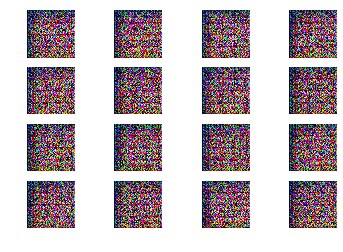

1 [D loss: 3.343765, acc.: 48.00%] [G loss: 0.011737]
2 [D loss: 3.150328, acc.: 48.50%] [G loss: 0.025495]
3 [D loss: 2.708357, acc.: 47.50%] [G loss: 0.056127]
4 [D loss: 2.743998, acc.: 43.00%] [G loss: 0.066232]
5 [D loss: 2.893390, acc.: 44.00%] [G loss: 0.044981]
6 [D loss: 2.804314, acc.: 39.50%] [G loss: 0.063534]
7 [D loss: 2.759930, acc.: 40.00%] [G loss: 0.080420]
8 [D loss: 2.828938, acc.: 36.00%] [G loss: 0.069248]
9 [D loss: 2.774023, acc.: 34.50%] [G loss: 0.077534]
10 [D loss: 2.828654, acc.: 32.50%] [G loss: 0.090054]
11 [D loss: 2.843971, acc.: 32.00%] [G loss: 0.090213]
12 [D loss: 2.811646, acc.: 31.50%] [G loss: 0.116384]
13 [D loss: 2.994757, acc.: 27.50%] [G loss: 0.078771]
14 [D loss: 2.739979, acc.: 28.00%] [G loss: 0.126996]
15 [D loss: 2.899302, acc.: 27.00%] [G loss: 0.130335]
16 [D loss: 3.037862, acc.: 24.00%] [G loss: 0.095547]
17 [D loss: 2.854234, acc.: 24.50%] [G loss: 0.142457]
18 [D loss: 2.983919, acc.: 18.00%] [G loss: 0.141590]
19 [D loss: 3.07994

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

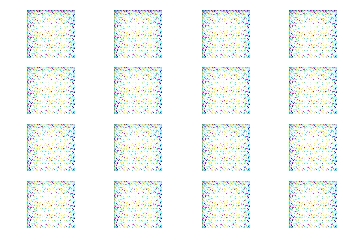

101 [D loss: 1.225371, acc.: 25.00%] [G loss: 3.050630]
102 [D loss: 0.998280, acc.: 46.00%] [G loss: 2.990640]
103 [D loss: 1.229679, acc.: 20.00%] [G loss: 2.981571]
104 [D loss: 1.029979, acc.: 71.00%] [G loss: 2.867066]
105 [D loss: 0.762921, acc.: 77.00%] [G loss: 2.648304]
106 [D loss: 0.957891, acc.: 58.50%] [G loss: 2.712809]
107 [D loss: 0.862161, acc.: 61.00%] [G loss: 2.853574]
108 [D loss: 0.814772, acc.: 75.00%] [G loss: 2.610978]
109 [D loss: 1.276667, acc.: 26.50%] [G loss: 2.905087]
110 [D loss: 0.783542, acc.: 76.50%] [G loss: 2.855825]
111 [D loss: 0.762911, acc.: 78.50%] [G loss: 2.571851]
112 [D loss: 0.742728, acc.: 77.50%] [G loss: 2.596542]
113 [D loss: 0.580338, acc.: 88.00%] [G loss: 2.488763]
114 [D loss: 0.617084, acc.: 82.50%] [G loss: 2.722156]
115 [D loss: 0.514133, acc.: 82.50%] [G loss: 2.609677]
116 [D loss: 0.643239, acc.: 82.50%] [G loss: 2.567203]
117 [D loss: 0.611143, acc.: 82.50%] [G loss: 2.689227]
118 [D loss: 0.576007, acc.: 84.00%] [G loss: 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

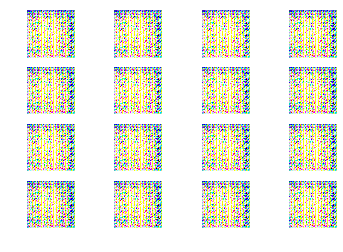

201 [D loss: 0.678720, acc.: 80.00%] [G loss: 3.363702]
202 [D loss: 0.802395, acc.: 39.50%] [G loss: 3.547194]
203 [D loss: 0.530611, acc.: 84.50%] [G loss: 3.021411]
204 [D loss: 0.800343, acc.: 42.00%] [G loss: 3.692220]
205 [D loss: 0.442297, acc.: 88.00%] [G loss: 3.100432]
206 [D loss: 0.619634, acc.: 52.00%] [G loss: 3.573099]
207 [D loss: 0.634801, acc.: 83.50%] [G loss: 3.274830]
208 [D loss: 0.518589, acc.: 83.50%] [G loss: 2.791284]
209 [D loss: 0.762013, acc.: 65.00%] [G loss: 3.376863]
210 [D loss: 0.430925, acc.: 89.50%] [G loss: 3.039951]
211 [D loss: 0.625171, acc.: 83.00%] [G loss: 3.220467]
212 [D loss: 0.430870, acc.: 89.50%] [G loss: 3.172204]
213 [D loss: 0.558161, acc.: 89.50%] [G loss: 2.991610]
214 [D loss: 0.542823, acc.: 85.00%] [G loss: 3.300409]
215 [D loss: 0.340724, acc.: 89.50%] [G loss: 2.877233]
216 [D loss: 0.330465, acc.: 91.50%] [G loss: 2.904571]
217 [D loss: 0.528326, acc.: 85.50%] [G loss: 3.476380]
218 [D loss: 0.426604, acc.: 85.00%] [G loss: 3.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

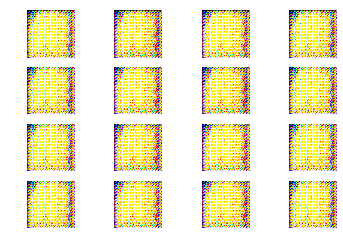

301 [D loss: 1.073611, acc.: 45.50%] [G loss: 3.432341]
302 [D loss: 0.467825, acc.: 81.00%] [G loss: 3.296270]
303 [D loss: 0.431496, acc.: 84.50%] [G loss: 1.277683]
304 [D loss: 1.395352, acc.: 43.50%] [G loss: 3.234605]
305 [D loss: 0.592910, acc.: 77.00%] [G loss: 3.066499]
306 [D loss: 0.998784, acc.: 34.00%] [G loss: 3.110288]
307 [D loss: 0.477578, acc.: 83.00%] [G loss: 2.894069]
308 [D loss: 0.581222, acc.: 80.50%] [G loss: 2.873491]
309 [D loss: 0.541348, acc.: 84.00%] [G loss: 3.679185]
310 [D loss: 0.355915, acc.: 85.50%] [G loss: 3.124247]
311 [D loss: 0.546567, acc.: 54.00%] [G loss: 4.930096]
312 [D loss: 0.402896, acc.: 86.50%] [G loss: 3.274176]
313 [D loss: 0.701496, acc.: 45.00%] [G loss: 4.386610]
314 [D loss: 0.455797, acc.: 83.00%] [G loss: 3.347671]
315 [D loss: 0.819163, acc.: 42.00%] [G loss: 4.329619]
316 [D loss: 0.452593, acc.: 83.00%] [G loss: 3.236686]
317 [D loss: 0.905127, acc.: 38.50%] [G loss: 3.873632]
318 [D loss: 0.486136, acc.: 84.00%] [G loss: 2.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

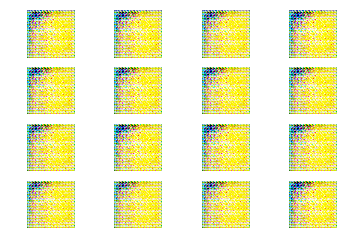

401 [D loss: 0.626889, acc.: 71.50%] [G loss: 2.050105]
402 [D loss: 0.516261, acc.: 82.50%] [G loss: 1.609182]
403 [D loss: 0.586132, acc.: 64.00%] [G loss: 2.014677]
404 [D loss: 0.566747, acc.: 78.50%] [G loss: 1.239396]
405 [D loss: 0.508148, acc.: 81.50%] [G loss: 1.204065]
406 [D loss: 0.616927, acc.: 76.50%] [G loss: 0.826118]
407 [D loss: 0.612951, acc.: 54.50%] [G loss: 1.015160]
408 [D loss: 0.593455, acc.: 78.00%] [G loss: 0.874245]
409 [D loss: 0.819379, acc.: 41.00%] [G loss: 1.116774]
410 [D loss: 0.560814, acc.: 81.00%] [G loss: 1.033202]
411 [D loss: 0.557064, acc.: 86.00%] [G loss: 0.943222]
412 [D loss: 0.793099, acc.: 54.50%] [G loss: 1.265682]
413 [D loss: 0.609849, acc.: 77.00%] [G loss: 0.972135]
414 [D loss: 1.148023, acc.: 30.00%] [G loss: 1.278053]
415 [D loss: 0.697349, acc.: 73.50%] [G loss: 1.293214]
416 [D loss: 1.047175, acc.: 51.00%] [G loss: 1.015394]
417 [D loss: 0.808990, acc.: 59.00%] [G loss: 1.530453]
418 [D loss: 0.814927, acc.: 64.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

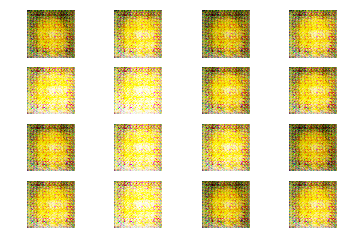

501 [D loss: 0.777725, acc.: 57.00%] [G loss: 1.435086]
502 [D loss: 0.859762, acc.: 44.50%] [G loss: 1.376475]
503 [D loss: 0.809982, acc.: 54.00%] [G loss: 1.384404]
504 [D loss: 0.766308, acc.: 52.50%] [G loss: 1.412223]
505 [D loss: 0.821320, acc.: 54.00%] [G loss: 1.345599]
506 [D loss: 0.822816, acc.: 49.00%] [G loss: 1.314023]
507 [D loss: 0.755437, acc.: 56.50%] [G loss: 1.348600]
508 [D loss: 0.768000, acc.: 58.00%] [G loss: 1.307091]
509 [D loss: 0.893246, acc.: 43.00%] [G loss: 1.320761]
510 [D loss: 0.889783, acc.: 51.00%] [G loss: 1.296456]
511 [D loss: 0.775305, acc.: 55.00%] [G loss: 1.317459]
512 [D loss: 0.893448, acc.: 48.50%] [G loss: 1.255610]
513 [D loss: 0.828323, acc.: 46.50%] [G loss: 1.218450]
514 [D loss: 0.930182, acc.: 31.50%] [G loss: 1.127988]
515 [D loss: 0.773904, acc.: 46.00%] [G loss: 1.179777]
516 [D loss: 0.968976, acc.: 37.50%] [G loss: 1.012849]
517 [D loss: 0.987665, acc.: 25.00%] [G loss: 0.997718]
518 [D loss: 0.789136, acc.: 55.50%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

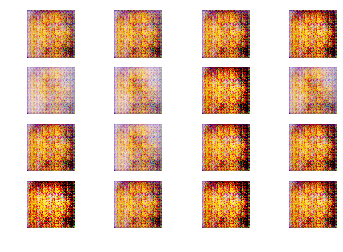

601 [D loss: 0.756468, acc.: 44.00%] [G loss: 1.435063]
602 [D loss: 0.802430, acc.: 70.00%] [G loss: 1.365829]
603 [D loss: 0.794990, acc.: 62.00%] [G loss: 1.362344]
604 [D loss: 0.657482, acc.: 68.00%] [G loss: 1.456445]
605 [D loss: 0.598370, acc.: 81.50%] [G loss: 1.563109]
606 [D loss: 0.593059, acc.: 80.50%] [G loss: 1.480726]
607 [D loss: 0.461223, acc.: 84.00%] [G loss: 1.440252]
608 [D loss: 0.692173, acc.: 46.00%] [G loss: 1.145230]
609 [D loss: 0.810915, acc.: 33.00%] [G loss: 1.210765]
610 [D loss: 0.621454, acc.: 75.50%] [G loss: 1.348009]
611 [D loss: 0.633620, acc.: 70.00%] [G loss: 1.184290]
612 [D loss: 0.632404, acc.: 76.50%] [G loss: 1.045718]
613 [D loss: 0.829806, acc.: 40.50%] [G loss: 0.883992]
614 [D loss: 0.631774, acc.: 73.00%] [G loss: 0.858009]
615 [D loss: 0.728864, acc.: 66.50%] [G loss: 0.647795]
616 [D loss: 0.710224, acc.: 58.00%] [G loss: 0.619899]
617 [D loss: 0.743094, acc.: 50.00%] [G loss: 0.608386]
618 [D loss: 0.717504, acc.: 65.00%] [G loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

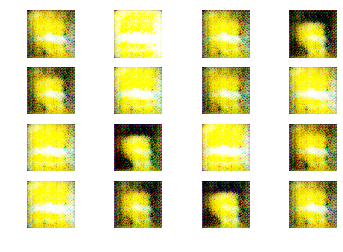

701 [D loss: 0.418777, acc.: 86.00%] [G loss: 1.720348]
702 [D loss: 0.462720, acc.: 84.50%] [G loss: 1.730644]
703 [D loss: 0.408959, acc.: 87.00%] [G loss: 1.740581]
704 [D loss: 0.351808, acc.: 90.50%] [G loss: 1.833942]
705 [D loss: 0.438431, acc.: 83.00%] [G loss: 1.699294]
706 [D loss: 0.590048, acc.: 78.50%] [G loss: 1.613254]
707 [D loss: 0.604983, acc.: 75.50%] [G loss: 1.488944]
708 [D loss: 0.528426, acc.: 82.00%] [G loss: 1.605373]
709 [D loss: 0.622049, acc.: 72.50%] [G loss: 1.443545]
710 [D loss: 0.758642, acc.: 52.50%] [G loss: 1.297783]
711 [D loss: 0.831268, acc.: 59.00%] [G loss: 1.420455]
712 [D loss: 0.938672, acc.: 41.50%] [G loss: 1.309655]
713 [D loss: 1.051319, acc.: 41.50%] [G loss: 1.475988]
714 [D loss: 1.155564, acc.: 35.00%] [G loss: 1.496056]
715 [D loss: 0.932669, acc.: 63.50%] [G loss: 1.620711]
716 [D loss: 0.976781, acc.: 36.00%] [G loss: 1.402975]
717 [D loss: 0.786361, acc.: 58.00%] [G loss: 1.507631]
718 [D loss: 0.735793, acc.: 61.50%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

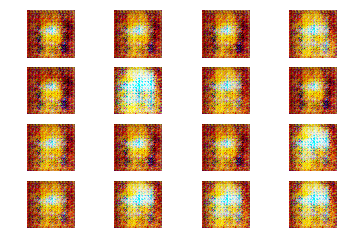

801 [D loss: 0.547294, acc.: 75.00%] [G loss: 1.568701]
802 [D loss: 0.499419, acc.: 83.00%] [G loss: 1.618274]
803 [D loss: 0.541496, acc.: 76.50%] [G loss: 1.566284]
804 [D loss: 0.598534, acc.: 77.50%] [G loss: 1.523491]
805 [D loss: 0.663739, acc.: 73.00%] [G loss: 1.434476]
806 [D loss: 0.625765, acc.: 75.00%] [G loss: 1.453798]
807 [D loss: 0.589591, acc.: 73.50%] [G loss: 1.435433]
808 [D loss: 0.500464, acc.: 80.50%] [G loss: 1.554789]
809 [D loss: 0.475596, acc.: 82.50%] [G loss: 1.528039]
810 [D loss: 0.556169, acc.: 75.00%] [G loss: 1.422791]
811 [D loss: 0.751221, acc.: 49.50%] [G loss: 1.142755]
812 [D loss: 0.632952, acc.: 63.00%] [G loss: 1.239294]
813 [D loss: 0.745390, acc.: 50.00%] [G loss: 1.144518]
814 [D loss: 0.867291, acc.: 37.00%] [G loss: 1.131747]
815 [D loss: 0.889850, acc.: 33.00%] [G loss: 1.100345]
816 [D loss: 0.803670, acc.: 50.00%] [G loss: 1.096119]
817 [D loss: 0.635692, acc.: 71.00%] [G loss: 1.188086]
818 [D loss: 0.698349, acc.: 63.50%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

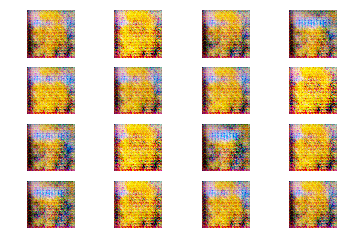

901 [D loss: 0.556781, acc.: 74.00%] [G loss: 1.758981]
902 [D loss: 0.567536, acc.: 76.00%] [G loss: 1.746509]
903 [D loss: 0.573323, acc.: 76.50%] [G loss: 1.664241]
904 [D loss: 0.643150, acc.: 68.00%] [G loss: 1.505762]
905 [D loss: 0.635105, acc.: 71.50%] [G loss: 1.608587]
906 [D loss: 0.513663, acc.: 82.50%] [G loss: 1.678400]
907 [D loss: 0.609192, acc.: 69.00%] [G loss: 1.641884]
908 [D loss: 0.695532, acc.: 65.50%] [G loss: 1.453877]
909 [D loss: 0.537482, acc.: 81.00%] [G loss: 1.482095]
910 [D loss: 0.582681, acc.: 74.00%] [G loss: 1.499445]
911 [D loss: 0.549589, acc.: 79.50%] [G loss: 1.475763]
912 [D loss: 0.517217, acc.: 81.50%] [G loss: 1.501428]
913 [D loss: 0.672646, acc.: 60.00%] [G loss: 1.342769]
914 [D loss: 0.749467, acc.: 58.00%] [G loss: 1.336498]
915 [D loss: 0.700681, acc.: 58.50%] [G loss: 1.316092]
916 [D loss: 0.672280, acc.: 59.00%] [G loss: 1.350306]
917 [D loss: 0.832388, acc.: 45.00%] [G loss: 1.219557]
918 [D loss: 0.782327, acc.: 44.50%] [G loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

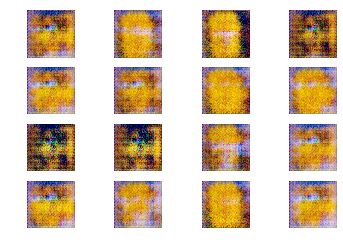

1001 [D loss: 0.832726, acc.: 36.00%] [G loss: 0.889813]
1002 [D loss: 0.901456, acc.: 24.50%] [G loss: 0.860679]
1003 [D loss: 0.797798, acc.: 35.00%] [G loss: 0.977486]
1004 [D loss: 0.822664, acc.: 33.00%] [G loss: 0.915083]
1005 [D loss: 0.851404, acc.: 31.00%] [G loss: 0.918929]
1006 [D loss: 0.882537, acc.: 27.50%] [G loss: 0.881377]
1007 [D loss: 0.904667, acc.: 24.00%] [G loss: 0.899107]
1008 [D loss: 0.817183, acc.: 33.00%] [G loss: 0.975794]
1009 [D loss: 0.789144, acc.: 37.50%] [G loss: 0.979920]
1010 [D loss: 0.781564, acc.: 46.50%] [G loss: 1.057090]
1011 [D loss: 0.777293, acc.: 48.50%] [G loss: 0.988015]
1012 [D loss: 0.814267, acc.: 44.00%] [G loss: 0.920652]
1013 [D loss: 0.736748, acc.: 41.50%] [G loss: 0.955288]
1014 [D loss: 0.706254, acc.: 57.00%] [G loss: 1.024036]
1015 [D loss: 0.746233, acc.: 49.50%] [G loss: 1.022277]
1016 [D loss: 0.714387, acc.: 57.00%] [G loss: 1.052868]
1017 [D loss: 0.692783, acc.: 60.50%] [G loss: 0.991454]
1018 [D loss: 0.820244, acc.: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

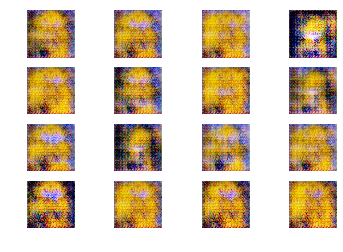

1101 [D loss: 0.768350, acc.: 44.00%] [G loss: 1.011247]
1102 [D loss: 0.666135, acc.: 59.50%] [G loss: 1.039536]
1103 [D loss: 0.752597, acc.: 52.00%] [G loss: 1.024335]
1104 [D loss: 0.719583, acc.: 50.00%] [G loss: 0.955558]
1105 [D loss: 0.719239, acc.: 56.50%] [G loss: 0.987988]
1106 [D loss: 0.779586, acc.: 43.00%] [G loss: 0.954176]
1107 [D loss: 0.792954, acc.: 45.00%] [G loss: 0.984995]
1108 [D loss: 0.840855, acc.: 29.00%] [G loss: 0.916322]
1109 [D loss: 0.801531, acc.: 41.00%] [G loss: 1.017006]
1110 [D loss: 0.754667, acc.: 47.00%] [G loss: 1.036884]
1111 [D loss: 0.733619, acc.: 55.00%] [G loss: 1.061526]
1112 [D loss: 0.765939, acc.: 46.00%] [G loss: 0.983256]
1113 [D loss: 0.830964, acc.: 36.00%] [G loss: 0.922939]
1114 [D loss: 0.714539, acc.: 46.50%] [G loss: 0.975049]
1115 [D loss: 0.831909, acc.: 36.50%] [G loss: 0.919750]
1116 [D loss: 0.779752, acc.: 44.00%] [G loss: 0.953238]
1117 [D loss: 0.806104, acc.: 36.50%] [G loss: 0.940527]
1118 [D loss: 0.801024, acc.: 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

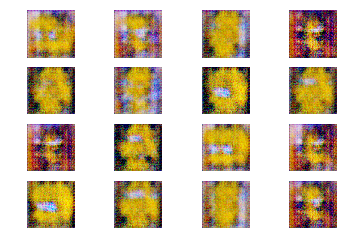

1201 [D loss: 0.867851, acc.: 22.00%] [G loss: 0.807632]
1202 [D loss: 0.805029, acc.: 35.00%] [G loss: 0.864461]
1203 [D loss: 0.902371, acc.: 30.50%] [G loss: 0.872514]
1204 [D loss: 0.819924, acc.: 33.50%] [G loss: 0.873862]
1205 [D loss: 0.841152, acc.: 28.00%] [G loss: 0.849799]
1206 [D loss: 0.810640, acc.: 34.50%] [G loss: 0.859731]
1207 [D loss: 0.803851, acc.: 36.50%] [G loss: 0.851066]
1208 [D loss: 0.886595, acc.: 23.50%] [G loss: 0.811906]
1209 [D loss: 0.822109, acc.: 34.00%] [G loss: 0.887717]
1210 [D loss: 0.818953, acc.: 34.00%] [G loss: 0.792199]
1211 [D loss: 0.898600, acc.: 22.00%] [G loss: 0.753678]
1212 [D loss: 0.823822, acc.: 31.00%] [G loss: 0.788562]
1213 [D loss: 0.827306, acc.: 33.00%] [G loss: 0.768543]
1214 [D loss: 0.839203, acc.: 30.00%] [G loss: 0.775797]
1215 [D loss: 0.751550, acc.: 43.50%] [G loss: 0.833141]
1216 [D loss: 0.836675, acc.: 30.00%] [G loss: 0.758406]
1217 [D loss: 0.801240, acc.: 33.00%] [G loss: 0.827389]
1218 [D loss: 0.927080, acc.: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

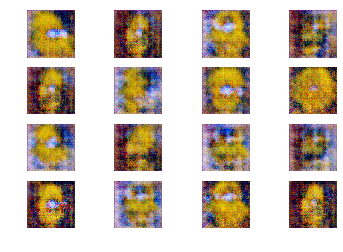

In [9]:
batch_size = 100
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, latent_dim))

for epoch in range(1301):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # loss function 
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch(noise, valid)

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % 100 == 0:
        generator.save("g{}.h5".format(epoch))
        generator.save_weights("gan-simposon-model.h5-" + str(epoch))
        discriminator.save_weights("desc-simposon-model.h5-" + str(epoch))
        gen_imgs = generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()